# Timeseries forecasting
Very simple example of trying to forecast a timeseries of electrical consuption at a plant. Data is from: https://github.com/zhouhaoyi/ETDataset/tree/main

Datasets are from two powerplants.
- Datasets m1, m2 are taken at minute level
- Datasets h1, h2 are taken at hour level

Description of the content: Each data point consists of 8 features, including the date of the point, the predictive value "oil temperature", and 6 different types of external power load features.

The target is the oil temperature (OT).

In [ ]:
import pandas as pd 

df = pd.read_csv("../data/ETT-small/ETTh1.csv")
print(f"{df.columns}, {df.size}")

# Multivariate
For multivariate, we want to use the correlation of the parallel time series in order to facilitate the prediction of the target. We need to concatenate the values of each timestep as a vector. We will then have a vector of size (timesteps * num_predictor)

In [ ]:
data= df.drop("date", axis="columns").to_numpy()
target = df['OT'].to_numpy()
print(f"Data shape: {data.shape}, target shape: {target.shape}")
print(data[0])

In [ ]:
import matplotlib.pyplot as plt

def visualize_ts(fig_name, ts, ts_name):
    # Adjusting the figure size
    fig = plt.figure()

    # Creating a plot
    plt.plot(ts, label=ts_name)

    # Adding a plot title and customizing its font size
    plt.title(fig_name)

    # Adding axis labels and customizing their font size
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.legend()
    plt.show()

In [ ]:
visualize_ts("visualization of target oil temperature", target, "Target")

In [ ]:
import matplotlib.pyplot as plt

def visualize_metrics(data, col_names):
    # Adjusting the figure size
    fig = plt.figure()

    for i in range(len(col_names)):
        plt.plot(data[:, i], label=col_names[i])

    # Adding a plot title and customizing its font size
    plt.title("Metrics")

    # Adding axis labels and customizing their font size
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.legend()
    plt.show()

col_names = df.columns[1:]
visualize_metrics(data[:1000], col_names)

# Model building
A very simple LSTM model

In [ ]:
import torch
import torch.nn as nn

class LstmForecaster(nn.Module):
    lstm_layer: nn.LSTM
    output_linear_layer: nn.Linear

    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm_layer = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.output_linear_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        #Pass through LSTM (L,N,Hin​)
        x, _ = self.lstm_layer(x)

        #Return linear layer prediction for next value based on the last very last hidden output of every batched input
        x = self.output_linear_layer(x[:, -1, :])
        return x

# Data preparation
Prepare data: Prepare trajectories for the forecasting task and put then in pytorch dataloards

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Task Constants
LOOKBACK= 150
FORECAST_SIZE = 50
number_of_metrics = data.shape[1]


#Apply scalign to the whole dataset before creating the trajectories
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(data.reshape(-1, number_of_metrics))

#Create trajectories
X, y = [], []
for i in range(0, len(target_scaled) - LOOKBACK):
    X.append(target_scaled[i:i+LOOKBACK])
    y.append(target_scaled[:,-1][i+LOOKBACK])

X, y = torch.FloatTensor(np.asarray(X)), torch.FloatTensor(np.asarray(y)).unsqueeze(-1)

print(f"Shape of X data: {X.shape}")
print(f"Shape of y data: {y.shape}")

test_size = 0.2  # Adjust the test set size as needed
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print(f"Shape of train dataset: {X_train.shape}")
print(f"Shape of test dataset: {X_test.shape}")

class SimpleDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

batch_size = 32
shuffle = False

train_dataset = SimpleDataset(X_train, Y_train)
test_dataset = SimpleDataset(X_test, Y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

visualize_ts("visualization of target oil temperature", target_scaled, "Target")

# Prepare visualization function of predicted / actual 

In [ ]:
import matplotlib.pyplot as plt

def plot_forecast(predicted_ts, expected_ts, lookback_size):
    # Adjusting the figure size
    fig = plt.figure()

    # Creating a plot
    plt.plot(predicted_ts, label="Predicted values", color="g")
    plt.plot(expected_ts, label="Expected values", color="b")

    # Adding a plot title and customizing its font size
    plt.title("Forecasting outcomes")
    plt.axvline(lookback_size-1, 0, 1, linestyle="dashed")

    # Adding axis labels and customizing their font size
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.legend()
    plt.show()

# Train model

In [ ]:
import numpy as np

# Model-related constants
INPUT_SIZE = number_of_metrics
HIDDEN_SIZE = 50
NUM_LAYERS = 1

model = LstmForecaster(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)

#Loop-related
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
train_losses = []
test_losses = []

for epoch in range(num_epochs):
  print(f"Epoch {epoch}...", end="")

  batch_train_losses = []
  for X_train, y_train in train_dataloader:
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    batch_train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  epoch_training_loss = np.mean(batch_train_losses)
  train_losses.append(epoch_training_loss)
  print(f"Mean training loss: {epoch_training_loss}")

  with torch.no_grad():
    test_batch_losses = []

    for X_test, y_test in test_dataloader:
      test_pred = model(X_test)

      loss = loss_fn(test_pred, y_test)
      test_batch_losses.append(loss.item())
    
    epoch_test_loss = np.mean(test_batch_losses)
    test_losses.append(epoch_test_loss)
    print(f'Test Loss: {epoch_test_loss:.4f}')


In [ ]:
def plot_losses(train_loss, test_loss):
    # Adjusting the figure size
    fig = plt.figure()

    # Creating a plot
    plt.plot(train_loss, label="Train loss", color="b")
    plt.plot(test_loss, label="Test loss", color="r")

    # Adding a plot title and customizing its font size
    plt.title("Plot of the losses over time")

    # Adding axis labels and customizing their font size
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')

    plt.legend()
    plt.show()

plot_losses(train_losses, test_losses)

# Output some predictions

In [ ]:
LOOKBACK = 500
FORECAST_SIZE = 100

def make_prediction(model, X, lookback, forecast_length, forecast_metrics):
    """ forecast_metrics is the forecast of shape (metrics-1) that tells us the metric values at timestap t+1..t+forecast as we only
    expect to predict the target and assume we have values for the metric in that time"""
    #Prepare a random dataset sample

    with torch.no_grad():
        predictions = []
        input_data = X.reshape(1, lookback, INPUT_SIZE)
        
        for i in range(forecast_length):
            input_tensor = torch.tensor(input_data).float()
            pred = model(input_tensor)
            predictions.append(pred[0][0])

            metric_tensor = forecast_metrics[i]
            forecasted_tensor = torch.cat((metric_tensor, pred.squeeze(0)), dim=0)

            input_data = np.append(input_data[:, 1:, :], forecasted_tensor).reshape(1, lookback, INPUT_SIZE)

        return predictions

# target_np is the timeseries as a simple numpy ndarray
idx = np.random.randint(0, len(target) - (LOOKBACK + FORECAST_SIZE) - 1)
print(f"Sampling {LOOKBACK} data from ID {idx}")
lookback = torch.tensor(target_scaled[idx:idx+LOOKBACK, :])
groundtruth_forecast = target_scaled[idx+LOOKBACK : idx+LOOKBACK+FORECAST_SIZE]

forecast_expected = groundtruth_forecast[:, -1]
masked_groundtruth_forecast = torch.tensor(groundtruth_forecast[:, 0:-1])

print(f"Generating forecast of length {FORECAST_SIZE}")
y_predicted = make_prediction(model, lookback, LOOKBACK, FORECAST_SIZE, masked_groundtruth_forecast)

plot_forecast(lookback[:, -1].reshape(LOOKBACK).tolist() + y_predicted, 
              lookback[:, -1].reshape(LOOKBACK).tolist() + forecast_expected.tolist(), 
              LOOKBACK)

# Perform a rolling evaluation of the timeseries to check the X+1 forecasting capability

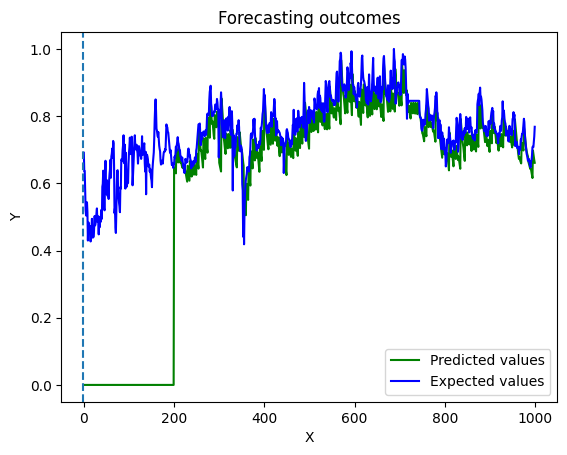

In [35]:
LOOKBACK = 200
STEP = 5

ts = target_scaled[:, -1]
# Predictions are shifted of the lookback data
predictions = [0] * LOOKBACK

with torch.no_grad():
    for i in range(0, ts.shape[0] - LOOKBACK - STEP, STEP):
        input_data = target_scaled[i:i+LOOKBACK, :].reshape(1, LOOKBACK, INPUT_SIZE)

        for j in range(STEP):
            input_tensor = torch.tensor(input_data).float()
            pred = model(input_tensor)
            predictions.append(pred[0][0])

            metric_tensor = torch.tensor(np.append(target_scaled[i + LOOKBACK + j + 1, :-2], pred))

            forecasted_tensor = torch.cat((metric_tensor, pred.squeeze(-1)), dim=0)
            input_data = np.append(input_data[:, 1:, :], forecasted_tensor).reshape(1, LOOKBACK, INPUT_SIZE)

plot_forecast(predictions[:1000], ts[:1000], 0)
